### Bibliotheken Importieren

In [25]:
# Standard library
import os
import math
import random
# Dataframe handling
import numpy as np
import pandas as pd
from scipy import stats
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mp
%matplotlib inline
# Seaborn plots
import seaborn as sns
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Plotly via cufflinks
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

### Hilfsfunktionen   
zur Erstellung von Kontingenztabellen

In [4]:
def calculate_row_total(df_counts):
    # Add a column for the row total and make sure the value is of type integer.
    df_counts['row_total'] = df_counts.sum(axis=1).astype('int')
    return df_counts

In [5]:
def calculate_row_percentage_table(df_counts):
    # We start to calculate the percentage table by copying the total count values table.
    df_percents = df_counts.copy()
    # Now do a percentage calculation row by row (unsing the row total as a dvider).
    for row in df_percents.index:
        # For precise division (and storing results) we convert the colum values into floats.
        df_percents.loc[row] = df_percents.loc[row].astype('float')
        # Now interate through the columns of the row and calculate the percent in relation to the row total.
        for column in df_percents.columns:
            percentage = df_percents.at[row, column] / df_percents.at[row, 'row_total']
            df_percents.at[row, column] = percentage
        # The total column is now 100 percent.
        df_percents.at[row, 'row_total'] = 1
    
    return df_percents

In [6]:
def calculate_column_total(df_counts):
    # Calculate the total of each new colum and make sure the value is of type integer.
    for column in df_counts.columns:
        df_counts.at['col_total',column] = df_counts[column].sum()
        df_counts[column] = df_counts[column].astype('int')
        
    return df_counts

In [7]:
def calculate_column_percentage_table(df_counts):
    # We start to calculate the percentage table by copying the total count values table.
    df_percents = df_counts.copy()
    # Now do a percentage calculation column by column (unsing the column total as a dvider).
    for column in df_percents.columns:
        # For precise division (and storing results) we convert the colum values into floats.
        df_percents[column] = df_percents[column].astype('float')
        # Now interate through the rows of the column and calculate the percent in relation to the column total.
        for row in df_percents.index:
            percentage = df_percents.at[row, column] / df_percents.at['col_total', column]
            df_percents.at[row, column] = round(percentage, 3)
        # The total row is now 100 percent.
        df_percents.at['col_total', column] = 1

    return df_percents

### Hilfsfunktionen   
zur Berechnung von Chi2

In [8]:
def calculate_crosstable_expected(df_crosstable_total):
    '''Calculates the expected total occurances for a given crosstable. This is required for Chi2 tests.'''
    # Copy the real occurences table as a starting table structure. We want to replace the values.
    df_crosstable_expect = df_crosstable_total.copy()
    # For precise division (and storing results) we convert the colum values into floats.
    df_crosstable_expect = df_crosstable_expect.astype('float')
    # Get the dimenaions of the table and find the sum (all) row and colum.
    row_count = df_crosstable_expect.index.size
    column_count = df_crosstable_expect.columns.size
    total_sum = df_crosstable_total.iat[row_count - 1, column_count - 1]
    # Now interate through each (but the total) cell and calculate the expected occurencies.
    for row_index in range(row_count - 1):
        for column_index in range(column_count - 1):
            row_sum = df_crosstable_total.iat[row_index, column_count - 1]
            column_sum = df_crosstable_total.iat[row_count - 1, column_index]
            # Calculate the expected occurrencies.
            df_crosstable_expect.iat[row_index, column_index] = round((row_sum * column_sum) / total_sum, 2)
        
    return df_crosstable_expect

In [9]:
def calculate_crosstable_difference(df_crosstable_total, df_crosstable_expect):
    '''Calculates the difference between the expected and real total occurances for a given crosstable.
    This is required for Chi2 tests.'''
    # Copy the expected occurences table as a starting table structure. We want to replace the values.
    df_crosstable_diff = df_crosstable_expect.copy()
    # Drop the total row and colum, as we do not need it anymore.
    df_crosstable_diff.drop('All', axis=1, inplace=True)
    df_crosstable_diff.drop('All', axis=0, inplace=True)
    # Get the dimenaions of the target table.
    row_count = df_crosstable_diff.index.size
    column_count = df_crosstable_diff.columns.size
    # Now interate through each cell and calculate the difference between the two occurrency tables.
    for row_index in range(row_count):
        for column_index in range(column_count):
            df_crosstable_diff.iat[row_index, column_index] = \
            df_crosstable_total.iat[row_index, column_index] - df_crosstable_expect.iat[row_index, column_index]
   
    return df_crosstable_diff

In [10]:
def calculate_crosstable_chi2(df_crosstable_diff, df_crosstable_expect):
    '''Calculates Chi2 from a table of expected values and a table holding the differences from these values.'''
    chi2 = 0
    row_count = df_crosstable_diff.index.size
    column_count = df_crosstable_diff.columns.size
    # Now interate through each cell and add to the chi2 value.
    for column_index in range(column_count):
        for row_index in range(row_count):
            difference = df_crosstable_diff.iat[row_index, column_index]
            expected = df_crosstable_expect.iat[row_index, column_index]
            chi2_add = math.pow(difference, 2) / expected
            chi2 = chi2 + chi2_add
            
    return chi2

In [11]:
def calculate_crosstable_contingency_pearson(df_crosstable_total, chi2, sigma):
    # Table dimensions without the total row or column.
    dim_x = df_crosstable_total.index.size - 1;
    dim_y = df_crosstable_total.columns.size - 1;
    # Number of samples found in the lower roght corner.
    n = df_crosstable_total.iat[dim_x, dim_y]
    # Normalized contingency coefficient.
    c_norm = math.sqrt(chi2 / (chi2 + n))
    # Smallest dimension of table.
    k = dim_x if (dim_x < dim_y) else dim_y
    # Maximum value c can reach.
    c_max = math.sqrt((k - 1) / k)
    # Corrected value for c fitting in range 0-1.
    c_corr = c_norm / c_max
    # Degree of freedom needed for chi2.
    deg_free = (dim_x - 1) * (dim_y - 1)
    # Find significant chi2 value for the chosen a significance level.
    chi2_significance = stats.chi2.isf(sigma, 55)
    # Create dataframe as a nice package.
    df_corr = pd.DataFrame(index=['Chi2','C_norm','C_max','C_corr','n_samples', 'k_min',
                                  'degree_free','sigma','Chi2_significant'], columns=['values'])
    df_corr.at['Chi2','values'] = chi2
    df_corr.at['C_norm','values'] = c_norm
    df_corr.at['C_max','values'] = c_max
    df_corr.at['C_corr','values'] = c_corr
    df_corr.at['n_samples','values'] = n
    df_corr.at['k_min','values'] = k
    df_corr.at['degree_free','values'] = deg_free
    df_corr.at['sigma','values'] = sigma
    df_corr.at['Chi2_significant','values'] = chi2_significance
    return df_corr

### Plot-Funktionen

In [12]:
def plot_obesity_barstack(x_title, df_bmi_percent):
    # Values of each group.
    bars0 = df_bmi_percent.loc['25-30'].tolist()
    bars1 = df_bmi_percent.loc['30-35'].tolist()
    bars2 = df_bmi_percent.loc['35-40'].tolist()
    bars3 = df_bmi_percent.loc['40+'].tolist()
    # Heights of stacked base bars.
    bars01 = (df_bmi_percent.loc['25-30'] + df_bmi_percent.loc['30-35']).tolist()
    bars012 = (df_bmi_percent.loc['25-30'] + df_bmi_percent.loc['30-35'] + df_bmi_percent.loc['35-40']).tolist()

    # The position of the bars on the x-axis.
    r = range(df_bmi_percent.columns.size)
    # Names of the x-axis groups and bar width
    names = df_bmi_percent.columns.tolist()
    barWidth = 1
    plt.figure(1, figsize=(20,8))

    # Create and stack bars on top of each other.
    plt.bar(r, bars0, color='#9999ff', edgecolor='white', width=barWidth)
    plt.bar(r, bars1, bottom=bars0, color='#70dbdb', edgecolor='white', width=barWidth)
    plt.bar(r, bars2, bottom=bars01, color='#ff9966', edgecolor='white', width=barWidth)
    plt.bar(r, bars3, bottom=bars012, color='#adad85', edgecolor='white', width=barWidth)

    # Custom X axis.
    plt.xticks(r, names, fontsize=12)
    plt.xlabel(x_title)

    # Legend for stacked bar colors.
    patch0 = mp.Patch(color='#9999ff', label='25-30 overweight')
    patch1 = mp.Patch(color='#70dbdb', label='30-35 obese 1')
    patch2 = mp.Patch(color='#ff9966', label='35-40 obese 2')
    patch3 = mp.Patch(color='#adad85', label='40+   obese 3')
    plt.legend(handles=[patch3, patch2, patch1, patch0])

    # Show graphic.
    plt.show()

![title](02_data_extra/nhanes_logo_image.jpg)

### Daten Importieren

In [13]:
path_input = os.path.join('00_data_input')
path_output = os.path.join('03_data_output')
path_categ = os.path.join(path_output, 'nhanes_categ.csv')

In [46]:
df_categ = pd.read_csv(path_categ)
df_categ.head()

id  CODE_status  CM_height  KG_weight  KG_M2_bmi  \
0  41475            3      154.7      138.9      58.04   
1  41476            1      120.4       22.0      15.18   
2  41477            1      167.1       83.9      30.05   
3  41478            1        NaN       11.5        NaN   
4  41479            1      154.4       65.7      27.56   

   CODE_bmi_category_youth  BINARY_gender  YEARS_age  CODE_race  \
0                      NaN              2         62          5   
1                      NaN              2          6          5   
2                      NaN              1         71          3   
3                      NaN              2          1          3   
4                      NaN              1         52          1   

   CODE_race_extended         ...           CAT2_age  CAT_bmi  LAB_bmi  \
0                 NaN         ...              60-69      4.0      40+   
1                 NaN         ...              01-09     -1.0    10-18   
2                 NaN         ...              70-79      2.0    30-35   
3                 NaN         ...              01-09      NaN  unknown   
4                 NaN         ...              50-59      1.0    25-30   

      STR_bmi  CAT1_race  CAT2_race  CAT_houshold_education  \
0      obese3   otherOld      other                       4   
1  underweigt   otherOld      other                       5   
2      obese1      white      white                       3   
3     unknown      white      white                       2   
4  overweight    mexican    mexican                       1   

   LAB_houshold_education  CAT_income_houshold  LAB_income_houshold  
0             4_AA-Degree                  6.0             025-035K  
1              5_College+                 12.0                100+K  
2            3_Highschool                  5.0             020-025K  
3           2_<12th-Grade                  3.0             010-015K  
4            1_<9th-Grade                  8.0             045-055K  

[5 rows x 38 columns]

# <font color='#0099ff'>BMI</font><font color='grey'> und </font><font color='#0099ff'>Einkommen</font>  
Die Untersuchung einer Korrelation von Body-Mass-Index und Einkommen ist der Ausgangspunkt für die Erforschung von sozioökonomischen Faktoren, welche in einem Zusammenhang mit der grassierenden Fettleibigkeit in den USA stehen könnten. Ähnlich wie zuvor mit den Daten aus dem Food Atlas, wird hier nun über den NHANES-Datensatz zunächst das Einkommen der Haushalte als Kernindikator herausgegriffen und in Beziehung zum BMI gesetzt.  

Beide Datenfelder sind über die Identifikationsnummer des untersuchten Teilnehmers verknüpft und wurden zuvor kategorisiert (Klassenbildung). Es handelt sich also um diskrete Daten mit Ordinalskalen. Somit lassen sich die absoluten Häufigkeiten der jeweiligen Merkmalsausprägungen zählen. Daraus ist eine Kontingenztablle mit m Reihen für die BMI-Klassen und n Spalten für die Einkommensgruppen zu erstellen. Mittels dieser Tabelle lassen sich schließlich mit Chi-Quadrat-Test die Unabhängigkeit der Variablen nachweisen oder aber Beziehungen erkennen.  

#### Hypothesen   
>Als Hypothesenpaar für diese Untersuchung werden aufgestellt:  
<b>Nullhypothese H0:</b> Übergewicht und Fettleibigkeit korrelieren negativ mit Einkommen. Das heißt, mit sinkenden Einkommen steigt die Wahrscheinlichkeit für ungesundes Körpergewicht.  
<b>Alternativhypthese H1:</b> Übergewicht und Einkommen korrelieren nicht. Es besteht kein erkennbarer Zusammenhang zwischen Fettleibigkeit und diesem sozioökonomischen Indikator.

#### Daten Selektieren   
Wir wählen zunächst die kategorisierten Tabellenspalten für BMI und Haushaltseinkommen aus.  
<b>BMI:</b> Es stehen folgende Merkmalsausprägungen für den Body-Mass-Index zur Verfügung: {10-18; 18-25; 25-30; 30-35; 35-40; 40+; unbekannt}.  
Diese Ausprägungen sind geordnet aber nicht in streng gleichförmigen Intervallen. Sie repräsentieren die gesundheitlich relevanten Kategorien: Untergewicht, Normalgewicht, Übergewicht, Fettleibigkeit 1-3. Die Benennungen der Intervalle weisen scheinbar Überschneidungen auf. Diese existieren jedoch nur Aufgrund abgekürzter Schreibweise (siehe Abschnitt zur Kategorisierung der Daten).  
<b>Einkommen:</b> Die Einkommensklassen beschreiben Intervalle mit unterschiedlicher (ansteigender) Breite. Dazu kommt wiederum der nach oben offene Maximalwert "100+K" sowie die weniger präzisen Ausweichkategorien "<20K" und ">20K". Also: {000-005K; 005-010K; 010-015K; 015-020K; 020-025K; 025-035K; 035-045K; 045-055K; 055-065K; 065-075K; 075-100K; 100+K; <20K; >20K; unbekannt}.  

<b>Fehlende Daten:</b> Von den 47873 Datenreihen enthalten einige die nicht aussagekräftigen "unbekannt" Einträge, welche ausgeschlossen werden. Damit reduziert sich der Datensatz auf 41800 Stichproben. Diese Menge scheint immer noch umfassend genug und deutlich weniger verzerrt als eine mit fiktiven Daten aufgefüllte Tabelle. Da die Einkommensklassen "<20K" und ">20K" ebenso wenig Auskunft geben und zudem die anderen Intervalle überdecken, müssen diese eventuell auch aus weiteren Test heraus genommen werden. Dies würde den Datensatz auf 39752 Reihen verkleinern.

In [15]:
# Select income and bmi columns from the categorized dataframe.
df_bmi_income = df_categ[['id','LAB_income_houshold','LAB_bmi']].copy()
# Drop rows with missing values.
df_bmi_income = df_bmi_income[df_bmi_income['LAB_income_houshold'] != 'unknown']
df_bmi_income = df_bmi_income[df_bmi_income['LAB_bmi'] != 'unknown']
# Rename the columns of the new dataframe for easier reding.
df_bmi_income.rename(columns={'LAB_bmi':'bmi','LAB_income_houshold':'houshold_income'}, inplace=True)
df_bmi_income.head()

id houshold_income    bmi
0  41475        025-035K    40+
1  41476           100+K  10-18
2  41477        020-025K  30-35
4  41479        045-055K  25-30
5  41480        035-045K  10-18

#### Kontingenztabellen BMI & Einkommensgruppen   
Der selektierte Datensatz kann über Pivotieren in eine Kontingenztabelle umgewandelt werden. Als Reihen werden nun die BMI-Klassen und als Spalten die Einkommensgruppen abgebildet. Die jeweiligen Ausprägungen werden dabei zu Zählungen der Häufigkeiten aggregiert. Des weiteren können der Werte über alle Reihen und Spalten aufsummiert werden. Eine weitere Tabelle der relativen Häufigkeiten erhalten wir über Division der absoluten Häufigkeiten durch die Spaltensumme. Dieser Tabelle ist schließlich zu entnehmen, wie in jeder Einkommensgruppe, die BMI-Klassen prozentual verteilt sind.

In [16]:
# Aggregate the count of observations for each income group and bmi class.
df_bmi_income_stats = df_bmi_income.groupby(['houshold_income','bmi']).count()
df_bmi_income_stats = df_bmi_income_stats.reset_index()
# Rename the id column as it is now the count of the samples.
df_bmi_income_stats.rename(columns={'id':'count'}, inplace=True)
# Transform the grouped table to spread out the variables along two axes (pivoting).
df_bmi_income_stats = df_bmi_income_stats.pivot(values='count',
                                                index='bmi',
                                                columns='houshold_income')
# Calculate the total of each row and column.
df_bmi_income_stats = calculate_column_total(df_bmi_income_stats)
df_bmi_income_stats = calculate_row_total(df_bmi_income_stats)
df_bmi_income_stats

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
bmi                                                                           
10-18                 282       406       577       647       752      1050   
18-25                 325       548       801       837       999      1505   
25-30                 210       393       732       704       854      1202   
30-35                 135       284       437       462       500       759   
35-40                  52       116       243       206       242       354   
40+                    59       131       156       162       197       312   
col_total            1063      1878      2946      3018      3544      5182   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K  100+K  \
bmi                                                                        
10-18                 770       593       442       368       736   1412   
18-25                1148       993       731       531      1167   2250   
25-30                1004       810       605       520       912   1587   
30-35                 625       472       363       317       566    845   
35-40                 282       235       183       143       245    322   
40+                   209       163       105        90       167    210   
col_total            4038      3266      2429      1969      3793   6626   

houshold_income  <020K  >020K  row_total  
bmi                                       
10-18              121    224       8380  
18-25              149    429      12413  
25-30              118    424      10075  
30-35               80    282       6127  
35-40               34     91       2748  
40+                 27     69       2057  
col_total          529   1519      41800

In [17]:
# Now use the column total as a divider for each row to calculate percentages.
df_bmi_income_percent = calculate_column_percentage_table(df_bmi_income_stats).drop('row_total', axis=1)
df_bmi_income_percent

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
bmi                                                                           
10-18               0.265     0.216     0.196     0.214     0.212     0.203   
18-25               0.306     0.292     0.272     0.277     0.282     0.290   
25-30               0.198     0.209     0.248     0.233     0.241     0.232   
30-35               0.127     0.151     0.148     0.153     0.141     0.146   
35-40               0.049     0.062     0.082     0.068     0.068     0.068   
40+                 0.056     0.070     0.053     0.054     0.056     0.060   
col_total           1.000     1.000     1.000     1.000     1.000     1.000   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K  100+K  \
bmi                                                                        
10-18               0.191     0.182     0.182     0.187     0.194  0.213   
18-25               0.284     0.304     0.301     0.270     0.308  0.340   
25-30               0.249     0.248     0.249     0.264     0.240  0.240   
30-35               0.155     0.145     0.149     0.161     0.149  0.128   
35-40               0.070     0.072     0.075     0.073     0.065  0.049   
40+                 0.052     0.050     0.043     0.046     0.044  0.032   
col_total           1.000     1.000     1.000     1.000     1.000  1.000   

houshold_income  <020K  >020K  
bmi                            
10-18            0.229  0.147  
18-25            0.282  0.282  
25-30            0.223  0.279  
30-35            0.151  0.186  
35-40            0.064  0.060  
40+              0.051  0.045  
col_total        1.000  1.000

### Visuelle Analyse von BMI in Einkommensgruppen   
Für die Untersuchung der Fettleibigkeit sind vor allem die BMI-Gruppen "25-30" (übergewichtig), "30-35" (fettleibig 1), 35-40" (fettleibig 2) und "40+" (fettleibig 3) interessant. Sie werden aus der Kontingenztabelle der prozentualen Verteilung gelesen und als gestapelte Balken für jede Einkommensgruppe dargestellt. 
<b>Das Resultat überrascht:</b> Zunächst wird das Ausmaß des Problems deutlich - in den USA liegt der Anteil an Menschen mit krankhafter Fettleibigkeit im Schnitt bei knapp 30%. Werden übergewichtige Personen hinzu gezählt, erreicht der Anteil fast 50%. Eine Anstieg des prozentualen Anteils von übergewichtigen oder fettleibigen Menschen mit sinkendem Einkommen ist in keiner Form zu erkennen. Stattdessen finden wir in den untersten Einkommensklassen sogar einen Rückgang. Dies ist bei einem Jahreseinkommen von unter 5.000 vielleicht nicht ganz verwunderlich. In der Spanne von 10.000-75.000 scheint die prozentuale Verteilung von allen betrachteten BMI-Klassen jedoch eher gleichförmig zu verlaufen. Jenseits von kleineren Schwankungen ist kein Trend auszumachen. Erst ab 75.000 sehen wir einen minimalen und ab 100.000 einen deutlichen Rückgang der Fettleibigkeit.  
<b>Besonderheiten:</b> sind in den übergreifenden Einkommensgruppen "<20K" und ">20K" zu finden. Hier scheint sich der vermutete Zusammenhang eher abzubilden. Bei jedoch gerade einmal 141 dargestellten Proben in der viel breiteren Einkommensklasse "<20K", sollte dieser Beobachtung jedoch nicht zu viel Bedeutung beigemessen werden.

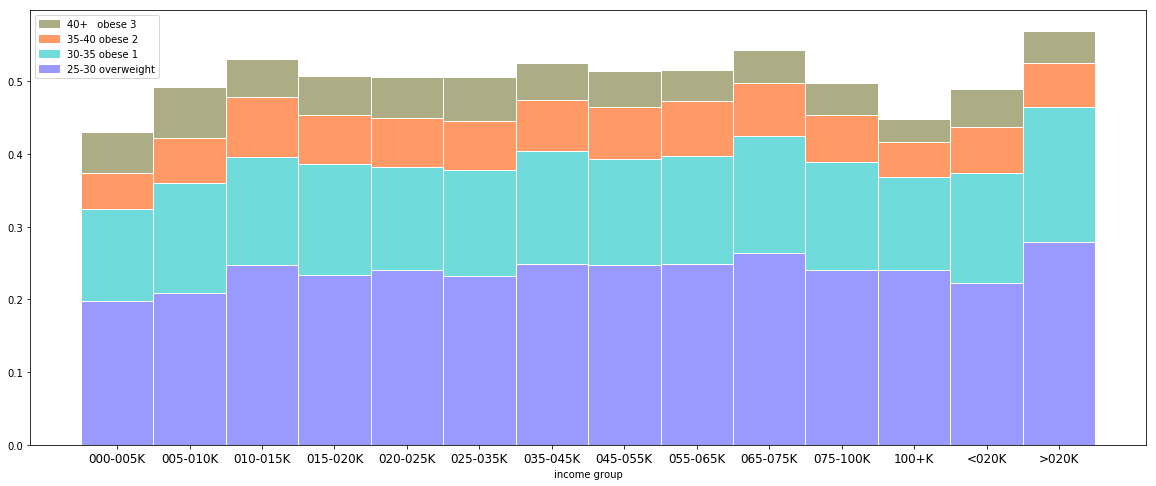

In [18]:
plot_obesity_barstack('income group', df_bmi_income_percent)

### Chi2-Test für BMI und Einkommensgruppe  
Um einen etwaigen Zusammenhang zwischen Fettleibigkeit und Einkommensklasse weiter mit statistischen Methoden zu erforschen, soll der Chi-Quadrat-Test zur Anwendung kommen. Dieser bietet sich zunächst an, da hier mit kategorischen Daten und einer Kontingenztabelle gearbeitet wurde. Der Test kann nur nachweisen ob die zwei Merkmale voneinander im Grundsatz statistisch unabhängig sind. Er basiert auf der Annahme, dass die zu erwartenden Werte innerhalb einer Kontingenztabelle über die Randsummen berechnet werden können. Wir betrachten nun die Differenzen zu den durch die Stichproben erhalten Werten und berechnen Chi-Quadrat nach folgender Formel:  
$$\chi^2 = \sum_{i=1}^{j}\sum_{k=1}^{m}\frac{(h_{ij} - \tilde{h_{ij}})^2}{\tilde{h_{ij}}}$$
>Die Hypothesen müssen also entsprechend der Aussagekraft des Tests präzisiert und umgestellt werden:  
<b>Nullhypothese H0:</b> Übergewicht und Fettleibigkeit sind stochastisch unabhängig.  
<b>Alternativhypothese H1:</b> Übergewicht bzw. Fettleibigkeit und Einkommensklasse sind voneinander abhängige Variablen.   
<b>Sigma:</b> Gewählt wird ein Signifikanzniveau von 5% (p = 0.05).

#### Kontingenztabelle und erwartete Häufigkeiten  
Die Kontingenztabelle für die Merkmale, Fettleibigkeit und Einkommensgruppe wurde bereits für die visuelle Analyse erstellt. Jedoch scheint hier eine weitere Angleichung der Qualität der Merkmalsausprägungen angebracht. Aus diesem Grund werden die wenig präzisen Einkommensgruppen "<20K" und ">20K" aus dem Test entfernt. Die Gesamtsumme der Stichproben fällt somit auf immer noch genügende 39.752 Ausprägungen. Aus den Randsummen der Kontingenztabelle werden die erwarteten Häufigkeiten nach der folgenden Formel ermittelt:   

$$\tilde{h_{ij}}=\frac{h_{i*}h_{*j}}{n}$$   

Somit lässt sich eine weitere Tabelle für die erwarteten Werte und schließlich eine dritte für die Differenz von Stichprobe und Erwartung aufsetzen. Diese beiden Tabellen werden schließlich genutzt um Chi-Quadrat entsprechend obiger Formel zu ermitteln.

In [19]:
# Drop the values which do not fit in the same categorization class and would distort the calculation.
df_bmi_income_redux = df_bmi_income[(df_bmi_income['houshold_income'] != '<020K') & \
                                    (df_bmi_income['houshold_income'] != '>020K')]
# Easier way to create the needed contingency (cross)table (via library function).
df_bmi_income_crosstable_total = pd.crosstab(df_bmi_income_redux['bmi'], df_bmi_income_redux['houshold_income'],
                                             margins=True)
df_bmi_income_crosstable_total

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
bmi                                                                           
10-18                 282       406       577       647       752      1050   
18-25                 325       548       801       837       999      1505   
25-30                 210       393       732       704       854      1202   
30-35                 135       284       437       462       500       759   
35-40                  52       116       243       206       242       354   
40+                    59       131       156       162       197       312   
All                  1063      1878      2946      3018      3544      5182   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K  100+K  \
bmi                                                                        
10-18                 770       593       442       368       736   1412   
18-25                1148       993       731       531      1167   2250   
25-30                1004       810       605       520       912   1587   
30-35                 625       472       363       317       566    845   
35-40                 282       235       183       143       245    322   
40+                   209       163       105        90       167    210   
All                  4038      3266      2429      1969      3793   6626   

houshold_income    All  
bmi                     
10-18             8035  
18-25            11835  
25-30             9533  
30-35             5765  
35-40             2623  
40+               1961  
All              39752

In [20]:
# Calculate the expected values for the contingency table.
df_bmi_income_crosstable_expect = calculate_crosstable_expected(df_bmi_income_crosstable_total)
df_bmi_income_crosstable_expect

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
bmi                                                                           
10-18              214.86    379.60    595.47    610.02    716.34   1047.43   
18-25              316.48    559.12    877.09    898.52   1055.12   1542.79   
25-30              254.92    450.37    706.49    723.75    849.89   1242.70   
30-35              154.16    272.36    427.24    437.68    513.97    751.52   
35-40               70.14    123.92    194.39    199.14    233.85    341.93   
40+                 52.44     92.64    145.33    148.88    174.83    255.63   
All               1063.00   1878.00   2946.00   3018.00   3544.00   5182.00   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K    100+K  \
bmi                                                                          
10-18              816.19    660.15    490.97    397.99    766.67  1339.30   
18-25             1202.20    972.36    723.16    586.21   1129.26  1972.70   
25-30              968.36    783.23    582.50    472.19    909.61  1588.99   
30-35              585.61    473.65    352.26    285.55    550.08   960.93   
35-40              266.44    215.50    160.28    129.92    250.28   437.21   
40+                199.20    161.11    119.82     97.13    187.11   326.87   
All               4038.00   3266.00   2429.00   1969.00   3793.00  6626.00   

houshold_income      All  
bmi                       
10-18             8035.0  
18-25            11835.0  
25-30             9533.0  
30-35             5765.0  
35-40             2623.0  
40+               1961.0  
All              39752.0

In [21]:
# Calculate the discrepency between real and expected values.
df_bmi_income_crosstable_diff = calculate_crosstable_difference(df_bmi_income_crosstable_total,
                                                                df_bmi_income_crosstable_expect)
df_bmi_income_crosstable_diff

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
bmi                                                                           
10-18               67.14     26.40    -18.47     36.98     35.66      2.57   
18-25                8.52    -11.12    -76.09    -61.52    -56.12    -37.79   
25-30              -44.92    -57.37     25.51    -19.75      4.11    -40.70   
30-35              -19.16     11.64      9.76     24.32    -13.97      7.48   
35-40              -18.14     -7.92     48.61      6.86      8.15     12.07   
40+                  6.56     38.36     10.67     13.12     22.17     56.37   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K   100+K  
bmi                                                                        
10-18              -46.19    -67.15    -48.97    -29.99    -30.67   72.70  
18-25              -54.20     20.64      7.84    -55.21     37.74  277.30  
25-30               35.64     26.77     22.50     47.81      2.39   -1.99  
30-35               39.39     -1.65     10.74     31.45     15.92 -115.93  
35-40               15.56     19.50     22.72     13.08     -5.28 -115.21  
40+                  9.80      1.89    -14.82     -7.13    -20.11 -116.87

In [22]:
# Calculate Chi2 for bmi and houshold income.
chi2_bmi_income = calculate_crosstable_chi2(df_bmi_income_crosstable_diff, df_bmi_income_crosstable_expect)
chi2_bmi_income

301.2133097283329

#### Normalisierter und korrigierter Kontingenzkoeffizient für BMI und Einkommensgruppe (nach Bravais-Pearson)     
Der Wert von 301,21 für Chi-Quadrat ist abhängig von der Anzahl der Merkmalsausprägungen und der Beobachtungen und somit noch nicht besonders aussagekräftig. Daher werden weitere abgleitete Kenngrößen ermittelt bevor die Tesenprüfung erfolgt. Der korrigierte Kontingenzkoeffizient nach Bravais-Person bringt den Wert von Chi-Qadrat in einen normalisierten Wertebereich von 0-1. Dafür wird zunächst der normierte Kontingenzkoeffizient nach folgender Formel ermittelt, wobei n = 39752 die Anzahl unserer Merkmalsausprägungen ist.   

$$C=\sqrt{\frac{\chi^2}{\chi^2 + n}}$$   

Dieser Wert wird mit durch Korrekturfaktor dividiert, um den Wertebereich von 0-1 voll auszuschöpfen. In diesem Fall ist die minimale Tabellendimension k = 6 (die Zahl der BMI-Ausprägungen).
$$C_{korr}=\frac{C}{C_{max}}\textrm{,}\quad C_{max}=\sqrt{\frac{k-1}{k}} \quad\textrm{mit}\quad k = min(x,y)$$ 

Für die Auswertung des Chi-Quadrat-Test wird schlielich noch die Zahl der Freiheitsgrade DF benötigt. Sie ist für die reduzierte Kontingenztabelle 55.

$$DF=(k-1)(m - 1) \quad\textrm{mit}\quad k=6 \quad\textrm{und}\quad m=12$$  

In [23]:
df_bmi_income_chi2 = calculate_crosstable_contingency_pearson(df_bmi_income_crosstable_total,
                                                              chi2_bmi_income, sigma=0.05)
df_bmi_income_chi2

values
Chi2                301.213
C_norm            0.0867198
C_max              0.912871
C_corr            0.0949968
n_samples             39752
k_min                     6
degree_free              55
sigma                  0.05
Chi2_significant    73.3115

#### Auswertung Chi-Quadrat Test   
Mit 55 Freiheitsgraden überschreiten wir nach Chi-Quadrat-Tabelle bei einem Wert von 73.311 das gewählte Signifikanzniveau von 5%. Das heiß die Wahrscheinlichkeit, das der Wert für Chi-Quadrat einen Wert von 73,311 annimmt liegt gerade bei 5%. Bei dieser geringen Wahrscheinlichkeit müssen wir von einer signifikanten Beobachtung sprechen und die Nullhypothese verwerfen. Da der berechnete Wert für die Merkmale BMI und Einkommensgruppe bei 301,213 und somit weit über 73,311 liegt, ist dies der Fall:   
><i>Die Nullhypothese, dass die untersuchten Merkmale stochastisch unabhängig sind, ist zu verwerfen.</i>    

Dies scheint den Ergebnissen der visuellen Analyse entgegen zu laufen. Es ist jedoch zu beachten, dass aus dem Chi-Quadrat-Test nur ein vager Zusammenhang abzuleiten ist. Es wird keine Aussage über die Form der Abhängigkeiten getroffen. Eine Betrachtung des korrigierten Kontingenzkoeffizienten (Pearson) gibt weitere Auskunft: Der Wert liegt mit 0,095 dicht bei 0. Die 9,5% stehen für eine verhältnismäßig schwache Abhängigkeit von BMI und Einommensgruppe.

### Lineare Regression und p-Wert für BMI und Einkommensgruppe   
Da die Hypothese einer Unabhängigkeit der von BMI und Einkommen verworfen wurde, ist die Alternativhypothese anyunehmen. Über die Art des Zusammenhungs dieser Variablen besteht jedoch weiterhin keine Klarheit. Daher wird in einem weiteren Schritt mittels linearer Regression und p-Wert auf eine lineare Korrelation getestestet. 

>In diesem Kontext ist ein neuen Hypothesenpaar aufzustellen:  
<b>Nullhypothese H0:</b> Es besteht keine lineare Korrelation zwischen BMI und Einkommensgruppe.   
<b>Alternativhypothese H1:</b> BMI und Einkommen antikorrellieren. Bei steigenderm Einkommen sinkt der prozentuale Anteil an Testpersonen mit Übergewicht und somit der durchschnittliche Body-Mass-Index.  
<b>Sigma:</b> Das gewählte Signifikanzniveau bleibt bei 5% (p = 0.05). 

#### Einschänkungen und modifizierte Datenselektion
Da für die lineare Regression und den damit verbundenen p-Test eigentlich stetige Daten oder zumindest Daten mit über Intervallskalen benötigt werden, ist diese Untersuchung nur eingeschränkt möglich. Einige der Probleme lassen sich jedoch durch eine leicht modifizierte Datenselektion beheben:  
<b>Der BMI</b> liegt nicht nur als kategorischer Wert vor, sondern kann aus den ursprünglichen Tabellen als genauer Wert extrahiert werden. Für dieses Merkmal liegen somit die verlangten stetige Daten vor.  

In [47]:
# Select income category and bmi columns from the categorized dataframe.
df_bmi_income_p = df_categ[['id','CAT_income_houshold','KG_M2_bmi','CAT_gender']].copy()
# Drop rows with missing values.
df_bmi_income_p = df_bmi_income_p.dropna()
df_bmi_income_p = df_bmi_income_p[df_bmi_income_p['CAT_income_houshold'] < 13]
# Rename the columns of the new dataframe for easier reding.
df_bmi_income_p.rename(columns={'KG_M2_bmi':'bmi','CAT_income_houshold':'income_code','CAT_gender':'gender'},
                       inplace=True)
# Minor dataframe clean up.
df_bmi_income_p = df_bmi_income_p.reset_index()
df_bmi_income_p.drop('index', axis=1, inplace=True)
df_bmi_income_p['income_code'] = df_bmi_income_p['income_code'].astype(int)
df_bmi_income_p.head()

id  income_code    bmi  gender
0  41475            6  58.04  female
1  41476           12  15.18  female
2  41477            5  30.05    male
3  41479            8  27.56    male
4  41480            7  17.93    male

<b>Das Einkommen</b> der Haushalte wurde hingegen nur kategorisch erfasst und mit einem numerisch geordneten Code von 1-14 betitelt. Dieser Code lässt sich auf einer Achsenskala abbilden. Es bleibt jedoch zu beachten, dass die Codes 13 und 14 für die aus oben beschriebenen Gründen auszuschließenden Klassen, "<020K" und ">020K", stehen. Reihen mit diesen Werten verwerfen wir auch hier. Schließlich bleibt die Einschränkung bestehen, das die codierten Einkommensintervalle bei höherem Einkommen an Breite gewinnen. Dieser Intervallsprung geschieht in Stufen.   
<b>Eine mögliche Lösung</b> ist die Annäherung an eine stetige Verteilung durch Zuweisung eines Zufallswertes innerhalb des codierten Intervalls. Alternativ kann auch der Mittelwert des Intervalls gewählt werden. Eine derartige Transformation der Daten birgt natürlich Gefahren. Diesen kann aber durch eine Gegenprüfung mit den orginalen kategorischen Daten entgegen gewirkt werden. Wir führen zwei mit unterschiedlichen Mängeln behaftete Tests zu einer Aussage zusammen.

In [62]:
# Create income colum for mean income of coded interval. Add another one for a random interval value.
for row in range(df_bmi_income_p.index.size):
    code = df_bmi_income_p.at[row,'income_code']
    if (code == 1):
        df_bmi_income_p.at[row,'income_mean'] = 2500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(0,5000)
    elif (code == 2):
        df_bmi_income_p.at[row,'income_mean'] = 7500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(5000,10000)
    elif (code == 3):
        df_bmi_income_p.at[row,'income_mean'] = 12500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(10000,15000)
    elif (code == 4):
        df_bmi_income_p.at[row,'income_mean'] = 17500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(15000,20000)
    elif (code == 5):
        df_bmi_income_p.at[row,'income_mean'] = 22500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(20000,25000)
    elif (code == 6):
        df_bmi_income_p.at[row,'income_mean'] = 30000
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(25000,35000)
    elif (code == 7):
        df_bmi_income_p.at[row,'income_mean'] = 40000
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(35000,45000)
    elif (code == 8):
        df_bmi_income_p.at[row,'income_mean'] = 50000
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(45000,55000)
    elif (code == 9):
        df_bmi_income_p.at[row,'income_mean'] = 60000
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(55000,65000)
    elif (code == 10):
        df_bmi_income_p.at[row,'income_mean'] = 70000
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(65000,75000)
    elif (code == 11):
        df_bmi_income_p.at[row,'income_mean'] = 87500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(75000,100000)
    elif (code == 12):
        df_bmi_income_p.at[row,'income_mean'] = 112500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(100000,125000)
        
df_bmi_income_p.head()

id  income_code    bmi  gender  income_mean  income_rand
0  41475            6  58.04  female      30000.0      31714.0
1  41476           12  15.18  female     112500.0     121011.0
2  41477            5  30.05    male      22500.0      22169.0
3  41479            8  27.56    male      50000.0      49164.0
4  41480            7  17.93    male      40000.0      41669.0

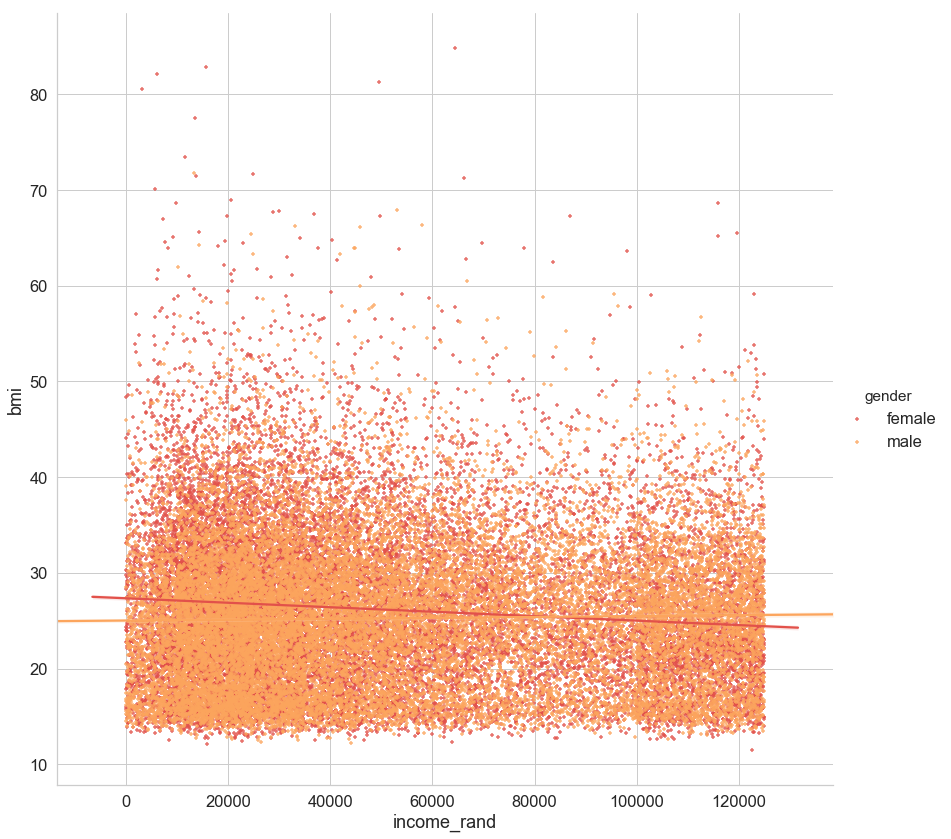

In [63]:
sns.set(style="whitegrid", palette='Spectral', color_codes=True, font_scale=1.5)
sns.lmplot(x='income_rand', y='bmi', hue='gender', data=df_bmi_income_p,
           size=12, markers='+', scatter_kws={"s": 10})

In [65]:
df_bmi_income_p[['bmi','income_rand']].corr('pearson')

bmi  income_rand
bmi          1.000000    -0.044848
income_rand -0.044848     1.000000

In [71]:
df_bmi_income_p_male = df_bmi_income_p[df_bmi_income_p['gender'] == 'male']
df_bmi_income_p_male[['bmi','income_rand']].corr('pearson')

bmi  income_rand
bmi          1.000000     0.023178
income_rand  0.023178     1.000000

In [72]:
df_bmi_income_p_female = df_bmi_income_p[df_bmi_income_p['gender'] == 'female']
df_bmi_income_p_female[['bmi','income_rand']].corr('pearson')

bmi  income_rand
bmi          1.000000    -0.099836
income_rand -0.099836     1.000000

In [69]:
df_bmi_income_p[['bmi','income_rand']].corr('spearman')

bmi  income_rand
bmi          1.000000    -0.025745
income_rand -0.025745     1.000000

In [78]:
houshold_income = df_bmi_income_p_male['income_rand'].tolist()
bmi = df_bmi_income_p_male['bmi'].tolist()
bmi_income_slope, bmi_income_intercept, bmi_income_r_value, bmi_income_p_value, bmi_income_std_err = \
stats.linregress(houshold_income, bmi)
# Create a dataframe for nice packaging.
df_houshold_income_lingres = pd.DataFrame(index=['slope','intercept','r','r2','p','std_error'],
                                          columns=['values'])
df_houshold_income_lingres.at['slope','values'] = bmi_income_slope
df_houshold_income_lingres.at['intercept','values'] = bmi_income_intercept
df_houshold_income_lingres.at['r','values'] = bmi_income_r_value
df_houshold_income_lingres.at['r2','values'] = bmi_income_r_value**2
df_houshold_income_lingres.at['p','values'] = bmi_income_p_value
df_houshold_income_lingres.at['std_error','values'] = bmi_income_std_err
df_houshold_income_lingres

values
slope      4.67011e-06
intercept      25.0225
r            0.0231779
r2         0.000537215
p           0.00113833
std_error  1.43503e-06

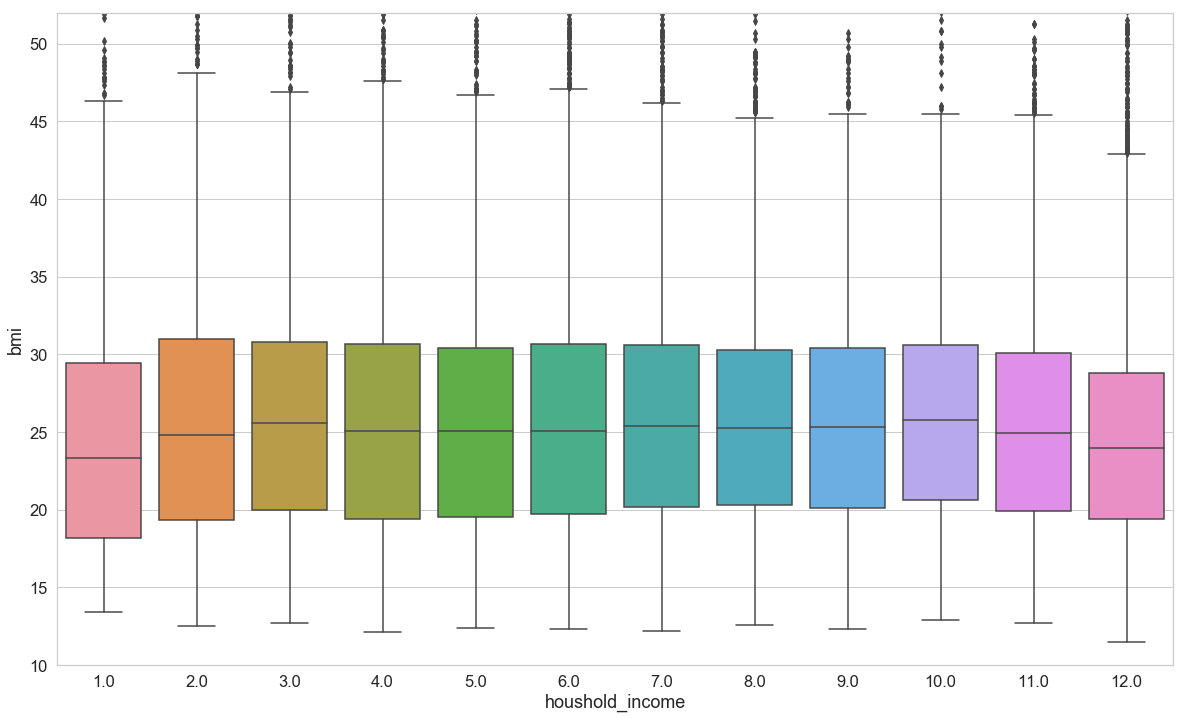

In [40]:
# Set plot style and scale.
sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=1.5)
fig, ax = plt.subplots(figsize=(20,12))
ax.set_ylim(10, 52)
# Draw a box plot to compare the bmi distribution of the different income groups.
sns.boxplot(x='houshold_income', y='bmi', data=df_bmi_income_code, ax=ax)

# <font color='#0099ff'>BMI</font><font color='grey'> related to </font><font color='#0099ff'>Houshold Education</font>
#### Select Data

In [28]:
# Select education level and bmi columns from the categorized dataframe.
df_bmi_education = df_categ[['id','KG_M2_bmi','LAB_houshold_education','LAB_income_houshold','CAT_gender']] 
# Drop rows with missing values.
df_bmi_education = df_bmi_education.dropna()
# Rename the columns of the new dataframe for easier reding.
df_bmi_education.rename(columns={'KG_M2_bmi':'bmi',
                                 'LAB_houshold_education':'houshold_education',
                                 'LAB_income_houshold':'houshold_income',
                                 'CAT_gender':'gender'}, inplace=True)
df_bmi_education.head()

id    bmi houshold_education houshold_income  gender
0  41475  58.04        4_AA-Degree        025-035K  female
1  41476  15.18         5_College+           100+K  female
2  41477  30.05       3_Highschool        020-025K    male
4  41479  27.56       1_<9th-Grade        045-055K    male
5  41480  17.93      2_<12th-Grade        035-045K    male

#### Median BMI for Education Level & Gender

In [29]:
# Drop the columns we do not need here.
df_bmi_education_median = df_bmi_education.drop(['id','houshold_income'], axis=1).copy()
# Aggregate the median bmi for each education level (separated by gender).
df_bmi_education_median = df_bmi_education.groupby(['gender','houshold_education']).median()
df_bmi_education_median = df_bmi_education_median.reset_index()
# Pivot the table to spread the variables on two axes.
df_bmi_education_median = df_bmi_education_median.pivot(values='bmi',
                                                        index='gender',
                                                        columns='houshold_education')
df_bmi_education_median

houshold_education  0_unknown  1_<9th-Grade  2_<12th-Grade  3_Highschool  \
gender                                                                     
female                  23.90         26.33          25.89          25.8   
male                    23.69         25.50          24.54          25.1   

houshold_education  4_AA-Degree  5_College+  
gender                                       
female                     25.4        23.4  
male                       25.2        24.7

#### Income Group for Education Level

In [30]:
# Drop the columns we do not need here.
df_education_income_stats = df_bmi_education.drop(['bmi','gender'], axis=1).copy()
# Aggregate the count of observations for each income group and education level.
df_education_income_stats = df_education_income_stats.groupby(['houshold_education','houshold_income']).count()
df_education_income_stats = df_education_income_stats.reset_index()
# Rename the id column as it is now the count of the samples.
df_education_income_stats.rename(columns={'id':'count'}, inplace=True)
# Transform the grouped table to spread out the variables along two axes (pivoting).
df_education_income_stats = df_education_income_stats.pivot(values='count',
                                                            index='houshold_education',
                                                            columns='houshold_income')
# Drop ambiguous data fields such as unknown income or education group.
df_education_income_stats = df_education_income_stats.drop(['0_unknown'], axis=0)
df_education_income_stats = df_education_income_stats.drop(['<020K','>020K','unknown'], axis = 1)
# Calculate the total of each row and column.
df_education_income_stats = calculate_column_total(df_education_income_stats)
df_education_income_stats = calculate_row_total(df_education_income_stats)
df_education_income_stats

houshold_income     000-005K  005-010K  010-015K  015-020K  020-025K  \
houshold_education                                                     
1_<9th-Grade             170       380       509       552       572   
2_<12th-Grade            281       512       732       628       773   
3_Highschool             270       440       750       817       930   
4_AA-Degree              246       403       729       758       918   
5_College+                76        94       167       207       284   
col_total               1043      1829      2887      2962      3477   

houshold_income     025-035K  035-045K  045-055K  055-065K  065-075K  \
houshold_education                                                     
1_<9th-Grade             650       453       309       118        76   
2_<12th-Grade           1014       571       399       280       224   
3_Highschool            1347      1045       845       547       407   
4_AA-Degree             1516      1274      1013       878       660   
5_College+               563       616       598       548       556   
col_total               5090      3959      3164      2371      1923   

houshold_income     075-100K  100+K  row_total  
houshold_education                              
1_<9th-Grade              98     79       3966  
2_<12th-Grade            266    199       5879  
3_Highschool             671    705       8774  
4_AA-Degree             1300   1537      11232  
5_College+              1328   3889       8926  
col_total               3663   6409      38777

In [31]:
# Now use the column total as a divider for each row to calculate percentages.
df_education_income_percent = calculate_column_percentage_table(df_education_income_stats)
df_education_income_percent = df_education_income_percent.drop(['row_total'], axis=1)
df_education_income_percent

houshold_income     000-005K  005-010K  010-015K  015-020K  020-025K  \
houshold_education                                                     
1_<9th-Grade        0.162991  0.207764  0.176308  0.186361  0.164510   
2_<12th-Grade       0.269415  0.279934  0.253550  0.212019  0.222318   
3_Highschool        0.258869  0.240569  0.259785  0.275827  0.267472   
4_AA-Degree         0.235858  0.220339  0.252511  0.255908  0.264021   
5_College+          0.072867  0.051394  0.057846  0.069885  0.081680   
col_total           1.000000  1.000000  1.000000  1.000000  1.000000   

houshold_income     025-035K  035-045K  045-055K  055-065K  065-075K  \
houshold_education                                                     
1_<9th-Grade        0.127701  0.114423  0.097661  0.049768  0.039522   
2_<12th-Grade       0.199214  0.144228  0.126106  0.118094  0.116485   
3_Highschool        0.264637  0.263956  0.267067  0.230704  0.211648   
4_AA-Degree         0.297839  0.321798  0.320164  0.370308  0.343214   
5_College+          0.110609  0.155595  0.189001  0.231126  0.289132   
col_total           1.000000  1.000000  1.000000  1.000000  1.000000   

houshold_income     075-100K     100+K  
houshold_education                      
1_<9th-Grade        0.026754  0.012326  
2_<12th-Grade       0.072618  0.031050  
3_Highschool        0.183183  0.110002  
4_AA-Degree         0.354900  0.239819  
5_College+          0.362544  0.606803  
col_total           1.000000  1.000000

Text(0.5,1,'Income Group & Houshold Income')

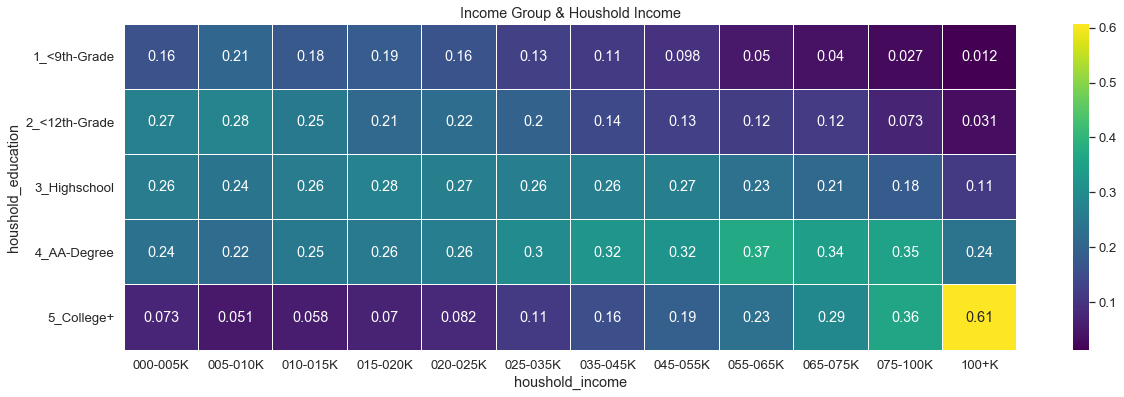

In [32]:
# Drop the total data fields.
df_education_income_heat = df_education_income_percent.drop(['col_total'], axis=0)
# Generate heatmap showing the income distribution among the different education levels.
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(20,6)) 
sns.heatmap(df_education_income_heat, ax=ax, cmap='viridis',
            linewidth=0.1, annot=True).set_title('Income Group & Houshold Income')

#### BMI Distribution for Education Level

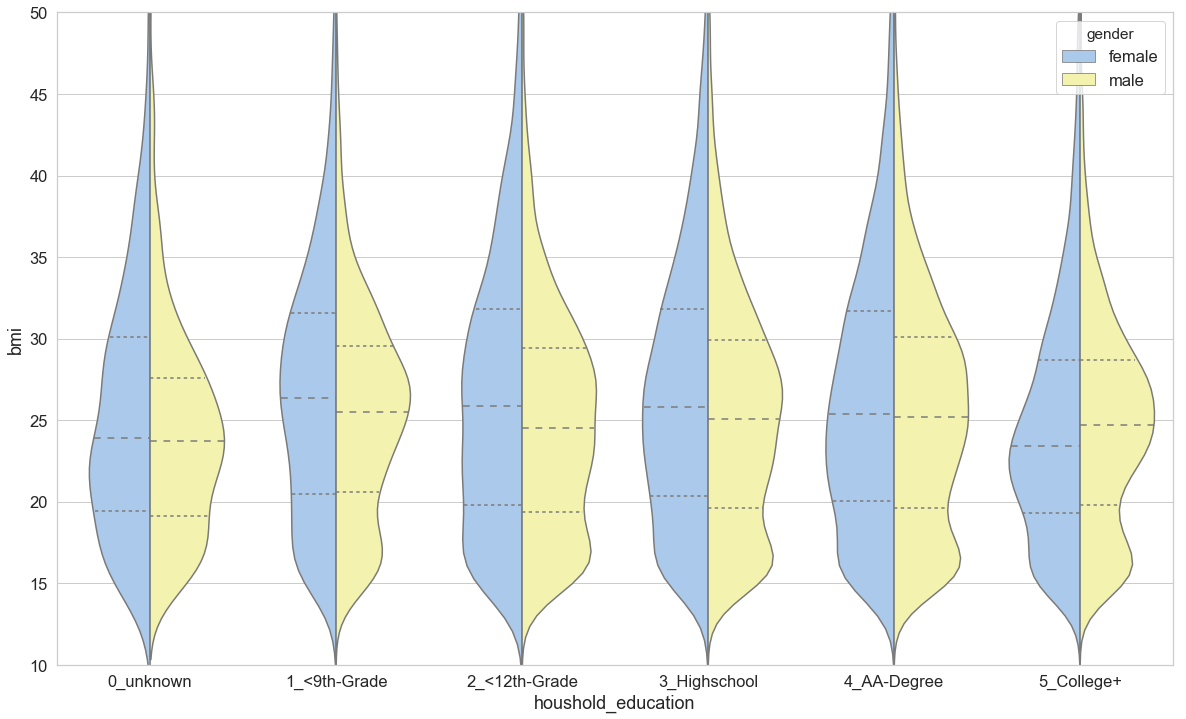

In [48]:
# Set plot style and scale.
sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=1.5)
fig, ax = plt.subplots(figsize=(20,12))
ax.set_ylim(10, 50)
# Draw a nested violinplot and split the violins for easier gender comparison.
sns.violinplot(x='houshold_education', y='bmi', hue='gender', data=df_bmi_education,
               split=True, inner='quart', palette={'male':'y','female':'b'}, ax=ax,
               order=['0_unknown','1_<9th-Grade','2_<12th-Grade','3_Highschool','4_AA-Degree','5_College+'])

# <font color='#0099ff'>BMI</font><font color='grey'> related to </font><font color='#0099ff'>Ethnical & Income Group</font>
#### Select Data

In [34]:
# Select the bmi, race and houshold income columns from the categorized data table.
df_bmi_income_race = df_categ[['id','KG_M2_bmi','LAB_bmi','CAT2_race','LAB_income_houshold']].copy()
# Drop missing values as our sample size is still representative and large.
df_bmi_income_race = df_bmi_income_race.dropna()
# Rename the columns of the new dataframe for easier reding.
df_bmi_income_race.rename(columns={'KG_M2_bmi':'bmi',
                                   'LAB_bmi':'bmi_group',
                                   'CAT2_race':'race',
                                   'LAB_income_houshold':'houshold_income'}, inplace=True)

#### BMI Distribution for Ethnical Group

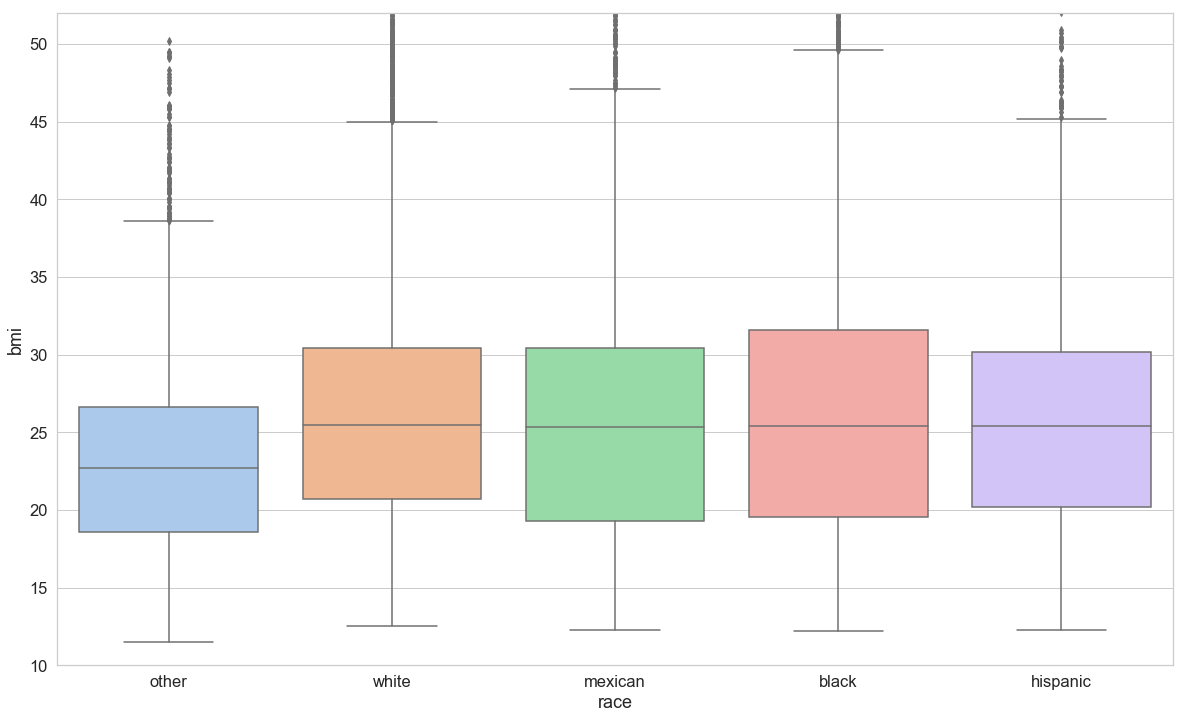

In [35]:
# Set plot style and scale.
sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=1.5)
fig, ax = plt.subplots(figsize=(20,12))
ax.set_ylim(10, 52)
# Draw a box plot to compare the bmi distribution of the different ethnic groups.
sns.boxplot(x='race', y='bmi', data=df_bmi_income_race, ax=ax)

#### BMI Group Probabilty for Ethnical Group

In [36]:
# For the bmi group counting we fo not need the exact bmi.
df_bmi_race_stats = df_bmi_income_race.drop('bmi', axis=1).copy()
# Aggregate the count of observations for each ethnic group and bmi class.
df_bmi_race_stats = df_bmi_race_stats.groupby(['race','bmi_group']).count()
df_bmi_race_stats = df_bmi_race_stats.reset_index()
# Rename the columns of the new dataframe for easier reding.
df_bmi_race_stats.rename(columns={'id':'count','bmi_group':'bmi'}, inplace=True)
# Transform the grouped table to spread out the variables along two axes (pivoting).
df_bmi_race_stats = df_bmi_race_stats.pivot(values='count', index='bmi', columns='race')
# Calculate the total of each new colum.
df_bmi_race_stats = calculate_column_total(df_bmi_race_stats)
df_bmi_race_stats = calculate_row_total(df_bmi_race_stats)
df_bmi_race_stats

race       black  hispanic  mexican  other  white  row_total
bmi                                                         
10-18       2091       909     1777   1247   2701       8725
18-25       2686      1403     2068   2157   4806      13120
25-30       2082      1287     2004   1074   4187      10634
30-35       1548       779     1274    423   2412       6436
35-40        782       315      536    137   1101       2871
40+          743       178      348     85    772       2126
col_total   9932      4871     8007   5123  15979      43912

In [37]:
df_bmi_race_percent = calculate_column_percentage_table(df_bmi_race_stats).drop('row_total', axis=1)
df_bmi_race_percent

race          black  hispanic   mexican     other     white
bmi                                                        
10-18      0.210532  0.186615  0.221931  0.243412  0.169034
18-25      0.270439  0.288031  0.258274  0.421042  0.300770
25-30      0.209625  0.264217  0.250281  0.209643  0.262031
30-35      0.155860  0.159926  0.159111  0.082569  0.150948
35-40      0.078735  0.064668  0.066941  0.026742  0.068903
40+        0.074809  0.036543  0.043462  0.016592  0.048313
col_total  1.000000  1.000000  1.000000  1.000000  1.000000

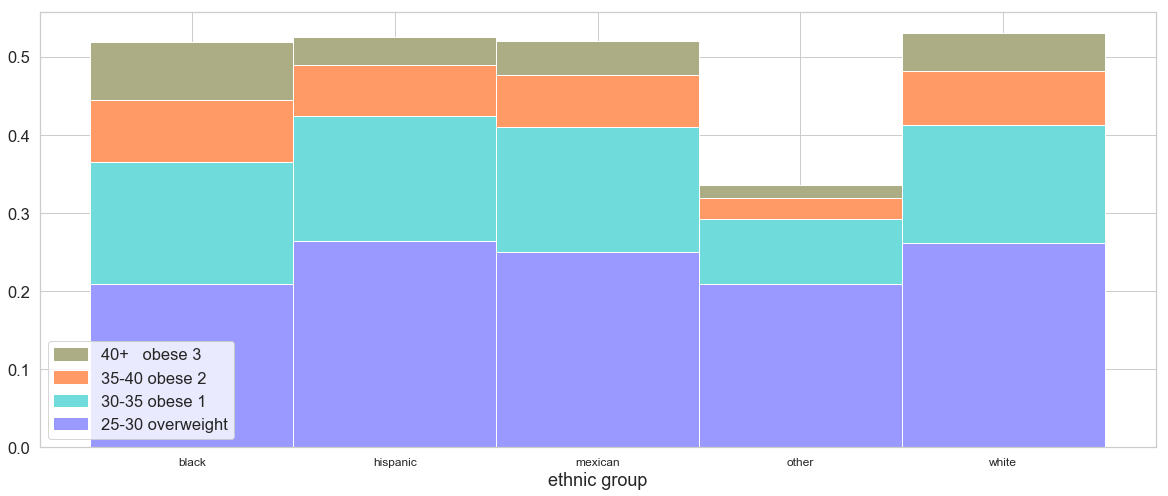

In [38]:
plot_obesity_barstack('ethnic group', df_bmi_race_percent)

In [39]:
# Aggregate the median bmi for each income level (separated by ethnic group).
df_bmi_income_race_median = df_bmi_income_race.groupby(['race','houshold_income']).median()
df_bmi_income_race_median = df_bmi_income_race_median.reset_index()
# Pivot the table to spread the variables on two axes.
df_bmi_income_race_median = df_bmi_income_race_median.pivot(values='bmi',
                                                            index='race',
                                                            columns='houshold_income')
df_bmi_income_race_median.head()

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
race                                                                          
black              22.685     24.20    24.515    24.565    24.400    25.000   
hispanic           23.200     25.46    25.600    26.100    25.235    25.925   
mexican            25.100     24.60    25.420    24.200    25.110    25.100   
other              21.400     23.85    23.340    23.700    23.200    22.500   
white              25.050     25.95    26.715    26.305    25.760    25.720   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K   100+K  \
race                                                                        
black              25.600     26.10    26.600    26.250    26.600  26.850   
hispanic           25.785     25.20    25.350    26.090    24.830  24.120   
mexican            26.135     25.35    25.755    27.025    25.400  24.615   
other              23.000     23.20    23.360    22.900    22.300  22.000   
white              25.900     25.57    25.500    26.100    25.365  24.300   

houshold_income   <020K   >020K  unknown  
race                                      
black            21.900  27.750   25.900  
hispanic         25.310  26.300   25.400  
mexican          23.900  26.925   25.700  
other            21.800  22.900   22.820  
white            28.245  25.800   25.295

Text(0.5,1,'Median BMI related to Ethnical Groups & Houshold Income')

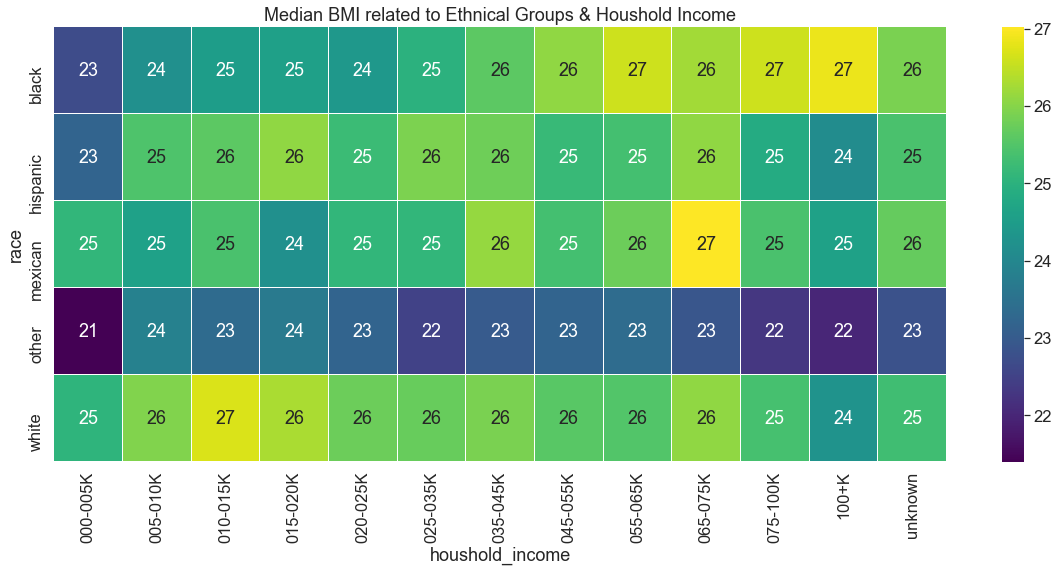

In [40]:
# Generate heatmap showing the median bmi for each income level an ethnic group.
fig, ax = plt.subplots(figsize=(20,8)) 
sns.heatmap(df_bmi_income_race_median.drop(['<020K','>020K'], axis=1), ax=ax, cmap='viridis',
            linewidth=0.1, annot=True).set_title('Median BMI related to Ethnical Groups & Houshold Income')

In [41]:
df_bmi_income_race_cluster = df_bmi_income_race_median.drop(['<020K','>020K','unknown'], axis=1)

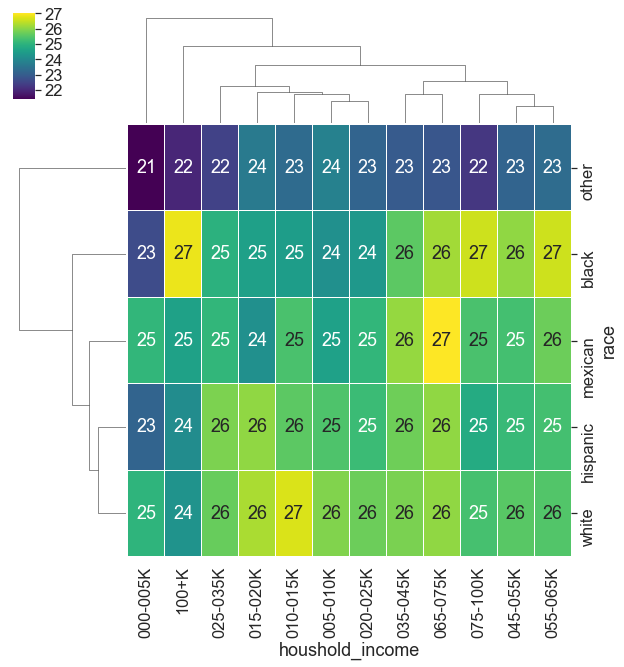

In [42]:
sns.clustermap(df_bmi_income_race_cluster, cmap='viridis', linewidth=0.1, annot=True)

In [54]:
# For the bmi group counting we do not need the exact bmi.
df_bmi_income_race_stats = df_bmi_income_race.drop('bmi', axis=1).copy()
# Aggregate the bmi group counts for each income level (separated by ethnic group).
df_bmi_income_race_stats = df_bmi_income_race_stats.groupby(['race','houshold_income','bmi_group']).count()
df_bmi_income_race_stats = df_bmi_income_race_stats.reset_index()
# Rename the columns of the new dataframe for easier reding.
df_bmi_income_race_stats.rename(columns={'id':'count','bmi_group':'bmi'}, inplace=True)
df_bmi_income_race_stats.head()

race houshold_income    bmi  count
0  black        000-005K  10-18    119
1  black        000-005K  18-25    124
2  black        000-005K  25-30     56
3  black        000-005K  30-35     46
4  black        000-005K  35-40     20

In [62]:
def extract_race_bmi_income_heatmap_table(dataframe, race):
    df_race_stats = dataframe[dataframe['race'] == race].copy()
    df_race_stats = df_race_stats.drop('race', axis=1)
    df_race_stats = df_race_stats.pivot(values='count', index='bmi', columns='houshold_income')
    df_race_stats = df_race_stats.fillna(0)
    df_race_stats = calculate_column_total(df_race_stats)
    df_race_percent = calculate_column_percentage_table(df_race_stats)
    df_race_percent['race'] = race
    df_race_percent = df_race_percent.drop('col_total', axis=0)
    return df_race_percent

In [63]:
# Calculate a bmi group percentage distribution for each ethnic group.
df_bmi_income_black_percent = extract_race_bmi_income_heatmap_table(df_bmi_income_race_stats, 'black')
df_bmi_income_mexican_percent = extract_race_bmi_income_heatmap_table(df_bmi_income_race_stats, 'mexican')
df_bmi_income_hispanic_percent = extract_race_bmi_income_heatmap_table(df_bmi_income_race_stats, 'hispanic')
df_bmi_income_white_percent = extract_race_bmi_income_heatmap_table(df_bmi_income_race_stats, 'white')
df_bmi_income_other_percent = extract_race_bmi_income_heatmap_table(df_bmi_income_race_stats, 'other')
# Merge all ethnic group tables by appending.
df_bmi_income_race_percent = df_bmi_income_black_percent
df_bmi_income_race_percent = df_bmi_income_race_percent.append(df_bmi_income_mexican_percent)
df_bmi_income_race_percent = df_bmi_income_race_percent.append(df_bmi_income_hispanic_percent)
df_bmi_income_race_percent = df_bmi_income_race_percent.append(df_bmi_income_white_percent)
df_bmi_income_race_percent = df_bmi_income_race_percent.append(df_bmi_income_other_percent)
# Show one result for better understanding.
df_bmi_income_black_percent

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
bmi                                                                           
10-18            0.303571  0.255023  0.258355  0.290141  0.243787  0.221239   
18-25            0.316327  0.281298  0.249357  0.233803  0.278107  0.276750   
25-30            0.142857  0.160742  0.204370  0.194366  0.203550  0.206758   
30-35            0.117347  0.148377  0.146530  0.139437  0.120710  0.142397   
35-40            0.051020  0.066461  0.074550  0.071831  0.072189  0.076428   
40+              0.068878  0.088099  0.066838  0.070423  0.081657  0.076428   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K     100+K  \
bmi                                                                           
10-18            0.188950  0.176316  0.160075  0.180180  0.181347  0.166667   
18-25            0.285083  0.267105  0.273070  0.263514  0.255181  0.249455   
25-30            0.223204  0.214474  0.239171  0.240991  0.198187  0.240741   
30-35            0.148066  0.164474  0.158192  0.175676  0.193005  0.184096   
35-40            0.077348  0.088158  0.092279  0.081081  0.090674  0.086057   
40+              0.077348  0.089474  0.077213  0.058559  0.081606  0.072985   

houshold_income     <020K     >020K   unknown   race  
bmi                                                   
10-18            0.268421  0.095930  0.158940  black  
18-25            0.331579  0.264535  0.304636  black  
25-30            0.189474  0.238372  0.231788  black  
30-35            0.100000  0.223837  0.174393  black  
35-40            0.057895  0.093023  0.088300  black  
40+              0.052632  0.084302  0.041943  black

# <font color='#0099ff'>BMI</font><font color='grey'> related to </font><font color='#0099ff'>Ethnical & Age Group</font>
#### Select Data

In [51]:
# Select bmi, race and age columns from the categorized dataframe.
df_bmi_age_race = df_categ[['KG_M2_bmi','CAT2_race','CAT1_age']]
df_bmi_age_race = df_bmi_age_race.dropna()
# Rename the columns of the new dataframe for easier reding.
df_bmi_age_race.rename(columns={'KG_M2_bmi':'bmi',
                                'CAT2_race':'race',
                                'CAT1_age':'age'}, inplace=True)

#### Median BMI for Ethnical & Age Group

In [52]:
df_bmi_age_race = df_bmi_age_race.groupby(['race','age']).median()
df_bmi_age_race = df_bmi_age_race.reset_index()
df_bmi_age_race = df_bmi_age_race.pivot(values='bmi', index='race', columns='age')
df_bmi_age_race = df_bmi_age_race.drop(['01-04','05-09','10-14'], axis=1)

Text(0.5,1,'Median BMI related to Ethnical & Age Groups')

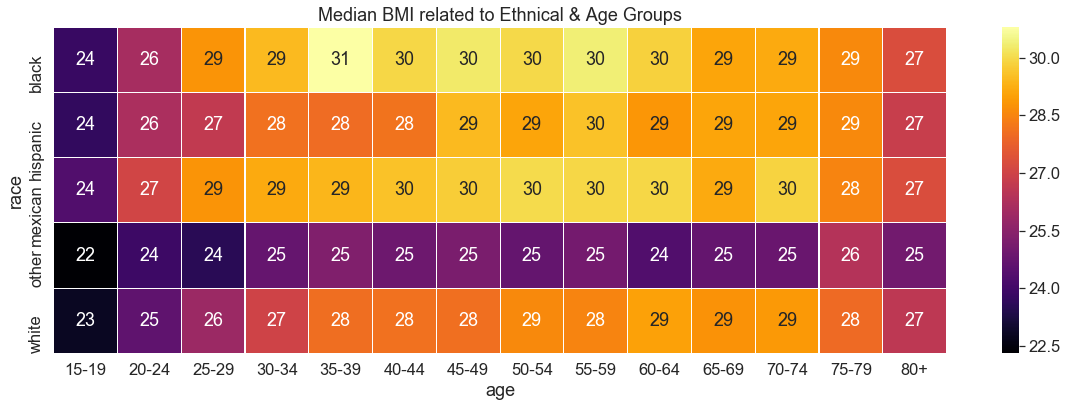

In [53]:
title_bmi_age_race = 'Median BMI related to Ethnical & Age Groups'
fig, ax = plt.subplots(figsize=(20,6)) 
sns.heatmap(df_bmi_age_race, ax=ax, cmap='inferno', linewidth=0.1, annot=True).set_title(title_bmi_age_race)